In [20]:
# Z,X,M,Y are numpy arrays with 0/1 entries
from brute_force import bounds_PY_doX1

import numpy as np

Z = np.array([1, 0, 1, 0, 1, 0])  # binary treatment
X = np.array([1, 0, 0, 1, 0, 1])  # binary confounder
M = np.array([0, 1, 1, 0, 1, 0])  # binary mediator
Y = np.array([1, 0, 1, 0, 1, 0])  # binary outcome

lb, ub = bounds_PY_doX1(Z, X, M, Y)  # purely observational
# with experiments:
lb2, ub2 = bounds_PY_doX1(Z, X, M, Y)
print(lb2, ub2)
print(ub2-lb2)
#p_doZ=N.A, p_doM=N.A: 0.4999999999999999
#p_doZ=0.5, p_doM=N.A: 0.5
#p_doZ=N.A, p_doM=0.7: 0.5
#p_doZ=0.5, p_doM=0.7: 0.4999999999999999

0.16666667 0.6666666699999999
0.4999999999999999


In [ ]:
# Observational samples (binary; 0/1). Length = 60.
Z = np.array([0,0,0,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,1,0], dtype=int)
X = np.array([0,0,0,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0], dtype=int)
M = np.array([1,0,0,1,1,1,1,1,1,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,1,0], dtype=int)
Y = np.array([0,0,0,1,0,1,1,1,1,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0], dtype=int)

# Interventional/experimental results you can feed as constraints (chosen completly aribitrary)
# p_doZ[z] = P(Y=1 | do(Z=1))
p_doZ = 0.568

# p_doM[m] = P(Y=1 | do(M=1))
p_doM = 0.8

lb, ub = bounds_PY_doX1(Z, X, M, Y, p_doM=p_doM, p_doZ=p_doZ)  # purely observational
print(ub-lb)
#none: 0.6206896529999999
#p_doM: 0.6206896580000001 (wider: The experiment result is not compatible with the observational data we had -> likely model misspecification)
#p_doZ: 0.4837241339999999
#both:  0.48372413400000003


0.48372413400000003


In [12]:
import numpy as np

# ---------- deterministic SCM (no noise in structural functions) ----------
def gen_observational_data(n=100_000, seed=213, pW=0.3, pU=0.6):
    rng = np.random.default_rng(seed)
    W = (rng.random(n) < pW).astype(int)
    U = (rng.random(n) < pU).astype(int)

    # Structural equations (deterministic given parents)
    Z = W
    X = Z * (1 - U)            # X = Z AND (NOT U)
    M = X
    Y = ((M & W) | U).astype(int)  # Y = (M AND W) OR U

    return Z, X, M, Y, W, U, pW, pU

def true_probs_from_scm(pW, pU):
    # Ground truth target
    p_doX1 = 1 - (1 - pW) * (1 - pU)       # P(W=1 or U=1)
    # Experiments
    p_doZ1 = pU + (1 - pU) * pW            # = P(U=1) + P(U=0)*P(W=1)
    p_doM1 = 1 - (1 - pW) * (1 - pU)       # same as do(X=1) in this SCM
    return p_doX1, p_doZ1, p_doM1


# ---------- demo runner (assumes bounds_PY_doX1 is already defined) ----------
def demo_bounds(seed=123):
    from brute_force import bounds_PY_doX1
    # Generate large-N observational data to kill sampling noise
    Z, X, M, Y, W, U, pW, pU = gen_observational_data(n=200_000, seed=seed, pW=0.3, pU=0.6)

    # Ground-truth values from SCM
    p_doX1_true, p_doZ1_true, p_doM1_true = true_probs_from_scm(pW, pU)

    # 1) Observational only
    lb_obs, ub_obs = bounds_PY_doX1(Z, X, M, Y)
    # 2) With do(Z=1)
    lb_Z, ub_Z = bounds_PY_doX1(Z, X, M, Y, p_doZ=p_doZ1_true)
    # 3) With do(M=1)
    lb_M, ub_M = bounds_PY_doX1(Z, X, M, Y, p_doM=p_doM1_true)
    # 4) With both
    lb_b, ub_b = bounds_PY_doX1(Z, X, M, Y, p_doZ=p_doZ1_true, p_doM=p_doM1_true)

    def show(tag, lb, ub):
        print(f"{tag:12s}  [{lb:.6f}, {ub:.6f}]  width={ub-lb:.6f}  "
              f"(reduction to observational: {(ub_obs - lb_obs) - (ub - lb):.6f})")

    print("SCM ground truth:")
    print(f"  P(Y=1 | do(X=1)) = {p_doX1_true:.6f}")
    print(f"  p_(Z=1)          = {p_doZ1_true:.6f}")
    print(f"  p_(M=1)          = {p_doM1_true:.6f}")
    print()
    show("observational", lb_obs, ub_obs)
    show("+ do(Z=1)",     lb_Z,   ub_Z)
    show("+ do(M=1)",     lb_M,   ub_M)
    show("+ both",        lb_b,   ub_b)


# --- run the demo ---

demo_bounds(12)


SCM ground truth:
  P(Y=1 | do(X=1)) = 0.720000
  p_(Z=1)          = 0.720000
  p_(M=1)          = 0.720000

observational  [0.119925, 1.000000]  width=0.880075  (reduction to observational: 0.000000)
+ do(Z=1)     [0.120030, 1.000000]  width=0.879970  (reduction to observational: 0.000105)
+ do(M=1)     [0.119925, 1.000000]  width=0.880075  (reduction to observational: 0.000000)
+ both        [0.120030, 1.000000]  width=0.879970  (reduction to observational: 0.000105)


   seed  lb_obs  ub_obs  width_obs  lb_doZ  ub_doZ  width_doZ  lb_doM  ub_doM  \
0     0  0.1184     1.0     0.8816  0.1185  1.0000     0.8815  0.1184     1.0   
1     1  0.1199     1.0     0.8801  0.1199  0.9984     0.8784  0.1199     1.0   
2     2  0.1194     1.0     0.8806  0.1197  1.0000     0.8803  0.1194     1.0   
3     3  0.1198     1.0     0.8802  0.1200  1.0000     0.8800  0.1198     1.0   
4     4  0.1212     1.0     0.8788  0.1212  0.9990     0.8778  0.1212     1.0   
5     5  0.1205     1.0     0.8795  0.1206  1.0000     0.8794  0.1205     1.0   
6     6  0.1215     1.0     0.8785  0.1215  0.9997     0.8782  0.1215     1.0   
7     7  0.1205     1.0     0.8795  0.1209  1.0000     0.8790  0.1205     1.0   
8     8  0.1206     1.0     0.8793  0.1206  0.9988     0.8782  0.1206     1.0   
9     9  0.1215     1.0     0.8785  0.1215  0.9967     0.8752  0.1215     1.0   

   width_doM  lb_both  ub_both  width_both  truth  p_doZ1_true  p_doM1_true  
0     0.8816   0.1185   1.0000

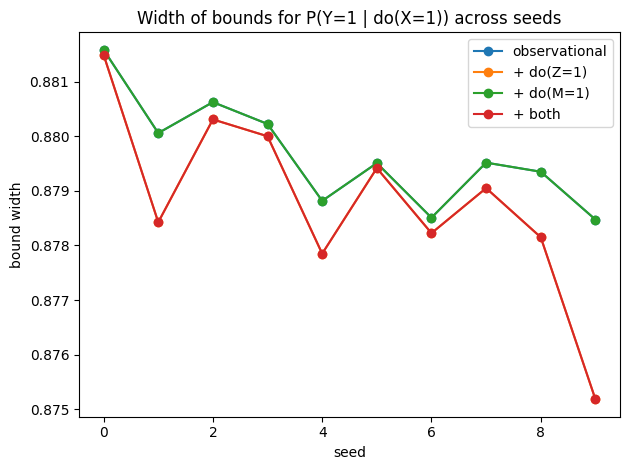

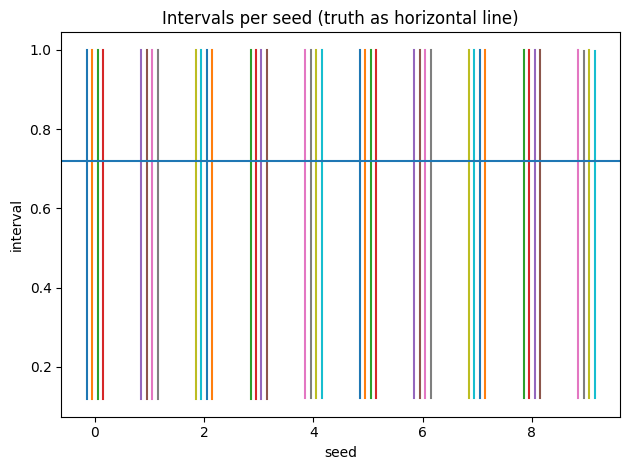

In [ ]:
# === 10-seed bounds demo with plots (requires: numpy, pandas, matplotlib, PuLP) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict
import pulp

# ---------- deterministic SCM (no noise in structural functions) ----------
def gen_observational_data(n=100_000, seed=0, pW=0.3, pU=0.6):
    rng = np.random.default_rng(seed)
    W = (rng.random(n) < pW).astype(int)
    U = (rng.random(n) < pU).astype(int)
    Z = W
    X = Z * (1 - U)                  # X = Z AND (NOT U)
    M = X
    Y = ((M & W) | U).astype(int)    # Y = (M AND W) OR U
    return Z, X, M, Y, W, U, pW, pU

def true_probs_from_scm(pW, pU):
    p_doX1 = 1 - (1 - pW) * (1 - pU)
    p_doZ1 = pU + (1 - pU) * pW
    p_doM1 = 1 - (1 - pW) * (1 - pU)
    return p_doX1, p_doZ1, p_doM1

# ---------- LP over response types for Z->X->M->Y with latent confounding ----------
TYPE_SPACE = list(product([0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]))
# t = (x0,x1,m0,m1,y00,y01,y10,y11)
def empirical_joint(Z, X, M, Y):
    Z = np.asarray(Z); X=np.asarray(X); M=np.asarray(M); Y=np.asarray(Y)
    n = len(Z)
    counts = defaultdict(int)
    for z,x,m,y in zip(Z,X,M,Y): counts[(int(z),int(x),int(m),int(y))]+=1
    return {k: v/n for k,v in counts.items()}

def bounds_PY_doX1(Z, X, M, Y, p_doZ=None, p_doM=None):
    pj = empirical_joint(Z,X,M,Y)
    nZ = {z: sum(p for (zz,_,_,_),p in pj.items() if zz==z) for z in [0,1]}

    prob = pulp.LpProblem("Bounds_doX1")
    p_vars = {(i,z): pulp.LpVariable(f"p_{i}_{z}", lowBound=0)
              for i,_ in enumerate(TYPE_SPACE) for z in [0,1]}

    # P(Z=z) matches data
    for z in [0,1]:
        prob += pulp.lpSum(p_vars[(i,z)] for i,_ in enumerate(TYPE_SPACE)) == nZ.get(z,0.0)

    # Match observational P(Z=z,X=x,M=m,Y=y)
    for z,x,m,y in product([0,1],[0,1],[0,1],[0,1]):
        mask = []
        for i,t in enumerate(TYPE_SPACE):
            x0,x1,m0,m1,y00,y01,y10,y11 = t
            x_z = x1 if z==1 else x0
            m_x = m1 if x==1 else m0
            y_mx = { (0,0): y00, (0,1): y01, (1,0): y10, (1,1): y11 }[(m,x)]
            if x_z==x and m_x==m and y_mx==y:
                mask.append(p_vars[(i,z)])
        prob += pulp.lpSum(mask) == pj.get((z,x,m,y), 0.0)

    # Helper: target P(Y=1 | do(X=1)) = sum_t mass_t * y_{m1,1}
    def target_expr():
        expr = []
        for i,t in enumerate(TYPE_SPACE):
            x0,x1,m0,m1,y00,y01,y10,y11 = t
            y_m1_1 = { (0,0): y00, (0,1): y01, (1,0): y10, (1,1): y11 }[(m1,1)]
            expr.append( (p_vars[(i,0)] + p_vars[(i,1)]) * y_m1_1 )
        return pulp.lpSum(expr)

    # Optional constraints: do(Z=1) and do(M=1)
    if p_doZ is not None:
        expr = []
        for i,t in enumerate(TYPE_SPACE):
            x0,x1,m0,m1,y00,y01,y10,y11 = t
            m_x1 = m1 if x1==1 else m0
            y_mx1 = { (0,0): y00, (0,1): y01, (1,0): y10, (1,1): y11 }[(m_x1, x1)]
            expr.append( (p_vars[(i,0)] + p_vars[(i,1)]) * y_mx1 )
        prob += pulp.lpSum(expr) == float(p_doZ)

    if p_doM is not None:
        expr = []
        for i,t in enumerate(TYPE_SPACE):
            x0,x1,m0,m1,y00,y01,y10,y11 = t
            for z in [0,1]:
                x_z = x1 if z==1 else x0
                y_1xz = { (0,0): y00, (0,1): y01, (1,0): y10, (1,1): y11 }[(1, x_z)]
                expr.append( p_vars[(i,z)] * y_1xz )
        prob += pulp.lpSum(expr) == float(p_doM)

    # Min
    prob_min = prob.copy()
    prob_min.sense = pulp.LpMinimize
    prob_min.setObjective(target_expr())
    prob_min.solve(pulp.PULP_CBC_CMD(msg=False))
    lb = pulp.value(prob_min.objective)

    # Max
    prob_max = prob.copy()
    prob_max.sense = pulp.LpMaximize
    prob_max.setObjective(target_expr())
    prob_max.solve(pulp.PULP_CBC_CMD(msg=False))
    ub = pulp.value(prob_max.objective)

    return lb, ub

# ---- run demo over 10 seeds ----
seeds = list(range(10))
records = []
pW, pU = 0.3, 0.6
p_doX1_true, p_doZ1_true, p_doM1_true = true_probs_from_scm(pW, pU)

for seed in seeds:
    Z, X, M, Y, *_ = gen_observational_data(n=120_000, seed=seed, pW=pW, pU=pU)
    lb_obs, ub_obs = bounds_PY_doX1(Z, X, M, Y)
    lb_Z, ub_Z   = bounds_PY_doX1(Z, X, M, Y, p_doZ=p_doZ1_true)
    lb_M, ub_M   = bounds_PY_doX1(Z, X, M, Y, p_doM=p_doM1_true)
    lb_b, ub_b   = bounds_PY_doX1(Z, X, M, Y, p_doZ=p_doZ1_true, p_doM=p_doM1_true)
    records.append({
        "seed": seed,
        "lb_obs": lb_obs, "ub_obs": ub_obs, "width_obs": ub_obs - lb_obs,
        "lb_doZ": lb_Z,   "ub_doZ": ub_Z,   "width_doZ": ub_Z - lb_Z,
        "lb_doM": lb_M,   "ub_doM": ub_M,   "width_doM": ub_M - lb_M,
        "lb_both": lb_b,  "ub_both": ub_b,  "width_both": ub_b - lb_b,
        "truth": p_doX1_true,
        "p_doZ1_true": p_doZ1_true,
        "p_doM1_true": p_doM1_true,
    })

df = pd.DataFrame.from_records(records)
print(df.round(4))

# ---- Plot widths per setting over seeds ----
plt.figure()
for col, label in [
    ("width_obs", "observational"),
    ("width_doZ", "+ do(Z=1)"),
    ("width_doM", "+ do(M=1)"),
    ("width_both", "+ both"),
]:
    plt.plot(df["seed"], df[col], marker="o", label=label)
plt.xlabel("seed"); plt.ylabel("bound width")
plt.title("Width of bounds for P(Y=1 | do(X=1)) across seeds")
plt.legend(); plt.tight_layout(); plt.show()

# ---- Plot intervals with ground-truth line for each seed ----
plt.figure()
for _, row in df.iterrows():
    x = row["seed"]
    offsets = [-0.15, -0.05, 0.05, 0.15]
    pairs = [("lb_obs","ub_obs"), ("lb_doZ","ub_doZ"), ("lb_doM","ub_doM"), ("lb_both","ub_both")]
    for off, (lbk, ubk) in zip(offsets, pairs):
        plt.plot([x+off, x+off], [row[lbk], row[ubk]])
plt.axhline(p_doX1_true)
plt.xlabel("seed"); plt.ylabel("interval")
plt.title("Intervals per seed (truth as horizontal line)")
plt.tight_layout(); plt.show()
sd

In [11]:
df[['width_obs', 'width_doM']]

,width_obs,width_doM
0,0.881583,0.881583
1,0.880058,0.880058
2,0.880625,0.880625
3,0.880225,0.880225
4,0.878817,0.878817
5,0.879508,0.879508
6,0.878508,0.878508
7,0.879517,0.879517
8,0.879350,0.879350
9,0.878475,0.878475
